# SAR Wave Parameter Retrieval Performance Evaluation

In paper, Section 3.2.3.4.

In [2]:
import numpy as np
import pandas as pd
from math import atan2, degrees, sqrt, atanh, pi
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


C:\Users\SZEERN\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# ROTATION OF IMAGES

Previously rotated -90 degrees during image processing

In [ ]:
# Directory containing your images
input_dir = "./ANNOTATIONS_DIP_2021"

# Directory to save rotated images
output_dir = "./ANNOTATIONS_DIP_2021"

# Ensure the output directory exists, if not create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List all files in the input directory
files = os.listdir(input_dir)

for file in files:
    # Check if the file is an image (you might want to add more checks if needed)
    if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
        # Open the image file
        img = Image.open(os.path.join(input_dir, file))
        
        # Rotate the image by 90 degrees
        rotated_img = img.transpose(Image.ROTATE_180)
        
        # Save the rotated image to the output directory
        rotated_img.save(os.path.join(output_dir, file))

print("Rotation completed!")


# Fast Fourier Transform

Retrieve wavelength, water depth, wave direction

In [ ]:
def calculate_2dft(subscene):
    """Calculate 2D FFT for a given subscene."""
    return np.fft.fftshift(np.fft.fft2(subscene))

def find_two_highest_peaks(magnitude_spectrum):
    """Find the two highest peaks in the FFT magnitude spectrum."""
    sorted_indices = np.argsort(magnitude_spectrum.flatten())[:-3:-1]  # Exclude the brightest point
    indices = np.unravel_index(sorted_indices, magnitude_spectrum.shape)
    return list(zip(indices[0], indices[1]))

def calculate_wavelength_and_depth(peak_indices, magnitude_spectrum_shape, Tp, pixel_size=10, g=9.81):
    """Calculate wavelength, wave direction, and depth based on the peak indices and magnitude spectrum shape.
    If calculating depth results in a math domain error, set depth to NaN."""
    N, M = magnitude_spectrum_shape
    Dx = abs(peak_indices[1][1] - peak_indices[0][1])
    Dy = abs(peak_indices[1][0] - peak_indices[0][0])

    gamma = pixel_size / sqrt((Dx / (2 * M))**2 + (Dy / (2 * N))**2)
    theta = degrees(atan2(Dy, Dx))

    try:
        h = (gamma / (2 * pi)) * atanh(2 * pi * gamma / (g * (Tp**2)))
    except ValueError:
        h = np.nan
    
    return gamma, theta, h


def plot_and_analyze_subscene(ax, subscene, Tp, pixel_size=10):
    """Plot contour lines on the FFT, mark the two highest peaks, and calculate wavelength, wave direction, and depth."""
    ft = calculate_2dft(subscene)
    magnitude_spectrum = np.log(np.abs(ft))
    magnitude_spectrum[int(magnitude_spectrum.shape[0] / 2), int(magnitude_spectrum.shape[1] / 2)] = magnitude_spectrum.min()
    peak_indices = find_two_highest_peaks(magnitude_spectrum)
    gamma, theta, h = calculate_wavelength_and_depth(peak_indices, magnitude_spectrum.shape, Tp, pixel_size)

    # Plot FFT magnitude spectrum and peaks
    im = ax.imshow(magnitude_spectrum, cmap='viridis')
    for peak in peak_indices:
        ax.plot(peak[1], peak[0], 'rx', markersize=5, markeredgewidth=1)
    ax.text(0.5, -0.2, f'Gamma: {gamma:.2f} meters\nTheta: {theta:.2f} degrees\nDepth (h): {h:.2f} meters', transform=ax.transAxes, fontsize=10, ha='center', va='center')
    
    return gamma, h

def plot_wave_direction_on_image(image_path, mask_path, pixel_size=10):
    """Plot the original SAR image with gridlines indicating subscenes and arrows showing wave direction for each subscene."""
    sar_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask_image = cv2.imread(mask_path)[:,:,2]
    if sar_image is None:
        raise ValueError(f"Error reading the image from {image_path}")
    
    # Dynamically adjust subscene size based on image dimensions
    subscene_size = min(sar_image.shape) // 6  # Example dynamic calculation
    
    # Calculate the number of subscenes in each dimension
    num_subscenes_rows, num_subscenes_cols = sar_image.shape[0] // subscene_size, 8
    
    # Initialize lists to store computed wave directions
    wave_directions = []

    # Create a figure to plot the image
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.imshow(sar_image, cmap='gray')
    ax.set_title('SAR Image with Wave Directions')
    
    subscenes_with_positions = []
    for i in range(num_subscenes_rows):
        for j in range(num_subscenes_cols):
            test_mask = mask_image[i * subscene_size:(i + 1) * subscene_size, j * subscene_size:(j + 1) * subscene_size]
            if 128 in test_mask: 
                test_subscene = sar_image[i * subscene_size:(i + 1) * subscene_size, j * subscene_size:(j + 1) * subscene_size]
                # Store subscene with its grid position
                subscenes_with_positions.append(((i, j), test_subscene))


    
    # Process each subscene
    for (i, j), subscene in subscenes_with_positions:
        ft = calculate_2dft(subscene)
        magnitude_spectrum = np.log(np.abs(ft))
        magnitude_spectrum[int(magnitude_spectrum.shape[0] / 2), int(magnitude_spectrum.shape[1] / 2)] = magnitude_spectrum.min()
        peak_indices = find_two_highest_peaks(magnitude_spectrum)
        _, theta, _ = calculate_wavelength_and_depth(peak_indices, magnitude_spectrum.shape, pixel_size)
        wave_directions.append(theta)

        # Correctly calculate the center of the subscene to place the arrow
        center_x = (j * subscene_size) + (subscene_size / 2)
        center_y = (i * subscene_size) + (subscene_size / 2)

        dx = 10 * np.cos(np.radians(theta))  # Arrow length in x direction
        dy = 10 * np.sin(np.radians(theta))  # Arrow length in y direction

        # Plot arrow indicating wave direction
        ax.arrow(center_x, center_y, dx, dy, head_width=3, head_length=5, fc='red', ec='red')
   


    
    # Add gridlines to indicate the subscenes
    for i in range(1, num_subscenes_rows):
        ax.axhline(i * subscene_size, color='blue', linewidth=1, linestyle='--')
    for j in range(1, num_subscenes_cols):
        ax.axvline(j * subscene_size, color='blue', linewidth=1, linestyle='--')
    
    plt.tight_layout()
    plt.show()

    # Calculate the overall average wave direction
    avg_wave_direction = np.mean(wave_directions)
    print(f"Average Wave Direction: {avg_wave_direction:.2f} degrees")
    
    return avg_wave_direction


def process_image(image_path, mask_path, Tp, pixel_size=10):
    """Process a single SAR image to compute and plot the average wavelength and depth, excluding NaN values for depth."""
    sar_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask_image = cv2.imread(mask_path)[:,:,2]
    
    if sar_image is None:
        raise ValueError(f"Error reading the image from {image_path}")
    
    # Dynamically adjust subscene size based on image dimensions
    subscene_size = min(sar_image.shape) // 6  # Example dynamic calculation

    # Initialize lists to store computed wavelengths and depths
    average_wavelengths, average_depths = [], []

    # Calculate the number of subscenes in each dimension and the total number of subscenes
    num_subscenes_rows, num_subscenes_cols = sar_image.shape[0] // subscene_size, 8
    total_subscenes = num_subscenes_rows * num_subscenes_cols

    subscenes = []
    ##Apply the filter to pick the subscenes with annotated pixel 
    for i in range(num_subscenes_rows):
        for j in range(num_subscenes_cols):
            test_mask = mask_image[i * subscene_size:(i + 1) * subscene_size, j * subscene_size:(j + 1) * subscene_size]
            test_subscene = sar_image[i * subscene_size:(i + 1) * subscene_size, j * subscene_size:(j + 1) * subscene_size]
            if 128 in test_mask: 
                subscenes.append(test_subscene)
                
    # Plotting
    num_rows = len(subscenes)//6+1
    num_cols = 6
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_cols))
    if num_rows == 1:
        # If axs is 1-dimensional (only one row), wrap it in another list to make it 2-dimensional
        axs = [axs]

    for i, subscene in enumerate(subscenes):
        row, col = i // num_cols, i % num_cols
        gamma, h = plot_and_analyze_subscene(axs[row][col], subscene, Tp, pixel_size)
        average_wavelengths.append(gamma)
        if not np.isnan(h):  # Only add non-NaN depth values to the list
            average_depths.append(h)
        axs[row][col].set_title(f'Subscene {i + 1}')

    # Assuming you might end up with more axes than subscenes, hide the unused ones
    for ax in axs[-1][len(subscenes) % num_cols:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()
    

    # Calculate the overall average wavelength and depth (excluding NaN values)
    avg_wavelength = np.mean(average_wavelengths)
    avg_depth = np.mean(average_depths) if average_depths else np.nan  # Calculate average only if there are non-NaN values
    print ("Average wavelength=",avg_wavelength, '',"Average depth=", avg_depth, )
        
    return avg_wavelength, avg_depth



# Assuming the Excel file path and the specific column names for image indices and Tp values
column_image_index = 'ImageIndex'  # Column name for image indices
column_tp_value = 'DPD'  # Column name for Tp values

def load_tp_values_as_list(excel_file_path, column_tp_value):
    """Load Tp values from an Excel file into a list."""
    df = pd.read_excel(excel_file_path)
    return df[column_tp_value].tolist()


def batch_process_images(directory_path, mask_path, excel_file_path, name, pixel_size=10):
    """Process all images in the specified directory in sequence, mapping to Tp values from the Excel file."""
    results = []
    tp_values = load_tp_values_as_list(excel_file_path, column_tp_value)
    
    # Sort the images by name to ensure order if needed
    image_files = sorted([f for f in os.listdir(directory_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    mask_files = sorted([f for f in os.listdir(mask_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    for index, files in enumerate(zip(image_files,mask_files)):
        if index < len(tp_values):  # Ensure there's a corresponding Tp value
            image_file, mask_file = files[0], files[1]
            Tp = tp_values[index]
            image_path = os.path.join(directory_path, image_file)
            mask_fp = os.path.join(mask_path, mask_file)
            avg_wavelength, avg_depth = process_image(image_path, mask_fp, Tp, pixel_size)
            avg_wave_direction = plot_wave_direction_on_image(image_path, mask_fp, pixel_size)
            results.append([image_file.split('.')[0], Tp, avg_wavelength, avg_depth, avg_wave_direction])
        else:
            print(f"No Tp value for {image_file}, skipping.")

    # Convert results to DataFrame and save as CSV
    df_results = pd.DataFrame(results, columns=['Image Index', 'Tp', 'Average Wavelength', 'Average Depth','Average Wave Direction'])
    df_results.to_csv(f"batch_process_results_{name}.csv", index=False)
    print("Results exported to batch_process_results.csv")



batch_process_images("./GROUNDTRUTH_DSTT_2019","./ANNOTATIONS_DSTT_2019","./FLORIDA_2019_FILTERED.xlsx","GROUNDTRUTH_DSTT_2019")
batch_process_images("./GROUNDTRUTH_DIP_2019","./ANNOTATIONS_DIP_2019","./FLORIDA_2019_FILTERED.xlsx","GROUNDTRUTH_DIP_2019")
batch_process_images("./INPAINTED_DSTT_2019","./ANNOTATIONS_DSTT_2019","./FLORIDA_2019_FILTERED.xlsx","INPAINTED_DSTT_2019")
batch_process_images("./INPAINTED_DIP_2019","./ANNOTATIONS_DIP_2019","./FLORIDA_2019_FILTERED.xlsx","INPAINTED_DIP_2019")
batch_process_images("./ORG_DSTT_2019","./ANNOTATIONS_DSTT_2019","./FLORIDA_2019_FILTERED.xlsx","ORG_DSTT_2019")
batch_process_images("./ORG_DIP_2019","./ANNOTATIONS_DIP_2019","./FLORIDA_2019_FILTERED.xlsx","ORG_DIP_2019")

batch_process_images("./GROUNDTRUTH_DSTT_2021","./ANNOTATIONS_DSTT_2021","./FLORIDA_2021_FILTERED.xlsx","GROUNDTRUTH_DSTT_2021")
batch_process_images("./GROUNDTRUTH_DIP_2021","./ANNOTATIONS_DIP_2021","./FLORIDA_2021_FILTERED.xlsx","GROUNDTRUTH_DIP_2021")
batch_process_images("./INPAINTED_DSTT_2021","./ANNOTATIONS_DSTT_2021","./FLORIDA_2021_FILTERED.xlsx","INPAINTED_DSTT_2021")
batch_process_images("./INPAINTED_DIP_2021","./ANNOTATIONS_DIP_2021","./FLORIDA_2021_FILTERED.xlsx","INPAINTED_DIP_2021")
batch_process_images("./ORG_DSTT_2021","./ANNOTATIONS_DSTT_2021","./FLORIDA_2021_FILTERED.xlsx","ORG_DSTT_2021")
batch_process_images("./ORG_DIP_2021","./ANNOTATIONS_DIP_2021","./FLORIDA_2021_FILTERED.xlsx","ORG_DIP_2021")

#For single image
#avg_wavelength, avg_depth = process_image("./GROUNDTRUTH_DIP_2019/00000.jpg")
#avg_wave_direction = plot_wave_direction_on_image("./GROUNDTRUTH_DIP_2019/00000.jpg")



# COMPARE INDIVIDUAL ATTRIBUTES

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def load_data(file_path):
    return pd.read_csv(file_path)

def calculate_metrics(actual, predicted):
    # Drop NaN values from both actual and predicted series to ensure matching indices
    valid_indices = actual.notna() & predicted.notna()
    actual_clean = actual[valid_indices]
    predicted_clean = predicted[valid_indices]
    
    mae = mean_absolute_error(actual_clean, predicted_clean)
    rmse = np.sqrt(mean_squared_error(actual_clean, predicted_clean))
    r2 = r2_score(actual_clean, predicted_clean)
    return mae, rmse, r2

def process_and_compare_models(gt_file_dstt, org_dstt_file, inp_dstt_file, gt_file_dip, org_dip_file, inp_dip_file):
    gt_dstt = load_data(gt_file_dstt)
    org_dstt = load_data(org_dstt_file)
    inp_dstt = load_data(inp_dstt_file)
    gt_dip = load_data(gt_file_dip)
    org_dip = load_data(org_dip_file)
    inp_dip = load_data(inp_dip_file)

    attribute_metrics_summary = {}
    metric_names = ['MAE', 'RMSE', 'R2']
    attributes = ['Average Wavelength', 'Average Depth', 'Average Wave Direction']
    for attribute in attributes:
        metrics_dstt_org = calculate_metrics(gt_dstt[attribute], org_dstt[attribute])
        metrics_dstt_inp = calculate_metrics(gt_dstt[attribute], inp_dstt[attribute])
        metrics_dip_org = calculate_metrics(gt_dip[attribute], org_dip[attribute])
        metrics_dip_inp = calculate_metrics(gt_dip[attribute], inp_dip[attribute])

        # Storing metrics for each attribute separately
        attribute_metrics_summary[attribute] = {
            'DSTT Synthetic': metrics_dstt_org,
            'DSTT Inpainted': metrics_dstt_inp,
            'DIP Synthetic': metrics_dip_org,
            'DIP Inpainted': metrics_dip_inp
        }

    # Displaying detailed metrics per attribute
    for attribute, metrics in attribute_metrics_summary.items():
        print(f"\nMetrics for {attribute}:")
        df = pd.DataFrame(metrics, index=metric_names).T  # Transpose to have combinations as rows and metrics as columns
        print(df)

# Please adjust file paths accordingly before executing the function.
process_and_compare_models('batch_process_results_GROUNDTRUTH_DSTT_2019.csv', 'batch_process_results_ORG_DSTT_2019.csv', 'batch_process_results_INPAINTED_DSTT_2019.csv', 'batch_process_results_GROUNDTRUTH_DIP_2019.csv', 'batch_process_results_ORG_DIP_2019.csv', 'batch_process_results_INPAINTED_DIP_2019.csv')
process_and_compare_models('batch_process_results_GROUNDTRUTH_DSTT_2021.csv', 'batch_process_results_ORG_DSTT_2021.csv', 'batch_process_results_INPAINTED_DSTT_2021.csv', 'batch_process_results_GROUNDTRUTH_DIP_2021.csv', 'batch_process_results_ORG_DIP_2021.csv', 'batch_process_results_INPAINTED_DIP_2021.csv')



Metrics for Average Wavelength:
                       MAE        RMSE         R2
DSTT Synthetic  169.093462  177.295251 -10.705544
DSTT Inpainted   41.848847   53.374942  -0.060895
DIP Synthetic   191.313553  198.083993 -11.002254
DIP Inpainted    38.820287   47.462576   0.310925

Metrics for Average Depth:
                      MAE       RMSE         R2
DSTT Synthetic  17.011732  18.970473 -30.845710
DSTT Inpainted   7.858521  10.695740  -2.858302
DIP Synthetic   16.891608  18.896455 -23.305746
DIP Inpainted    5.935582   8.028353   0.087070

Metrics for Average Wave Direction:
                      MAE       RMSE        R2
DSTT Synthetic  25.117612  29.232788 -3.723001
DSTT Inpainted  13.938392  16.907042 -0.579839
DIP Synthetic   21.759091  27.506739 -2.672984
DIP Inpainted   10.122415  11.958370  0.305800

Metrics for Average Wavelength:
                      MAE        RMSE        R2
DSTT Synthetic  95.623609  101.255741 -8.821490
DSTT Inpainted  10.741057   13.159431  0.834113


# COMPARE OVERALL PERFORMANCE

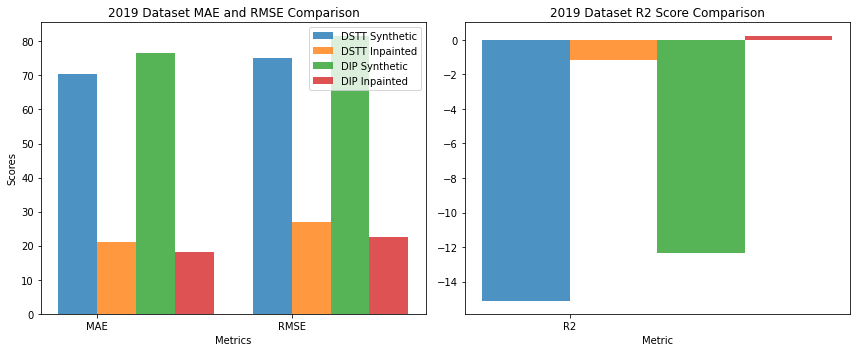

Average Metrics (MAE, RMSE, R2) for each combination:
                       MAE       RMSE         R2
DSTT Synthetic  70.407602  75.166171 -15.091418
DSTT Inpainted  21.215253  26.992575  -1.166345
DIP Synthetic   76.654751  81.495729 -12.326995
DIP Inpainted   18.292761  22.483100   0.234598


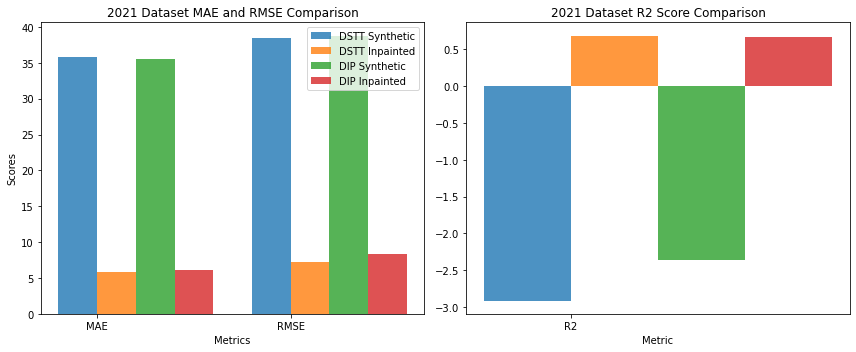

Average Metrics (MAE, RMSE, R2) for each combination:
                       MAE       RMSE        R2
DSTT Synthetic  35.855827  38.506906 -2.911432
DSTT Inpainted   5.851982   7.198184  0.686829
DIP Synthetic   35.539532  38.699085 -2.360123
DIP Inpainted    6.063861   8.293983  0.670360


In [5]:
def load_data(file_path):
    return pd.read_csv(file_path)

def calculate_metrics(actual, predicted):
    # Drop NaN values from both actual and predicted series to ensure matching indices
    valid_indices = actual.notna() & predicted.notna()
    actual_clean = actual[valid_indices]
    predicted_clean = predicted[valid_indices]
    
    mae = mean_absolute_error(actual_clean, predicted_clean)
    rmse = np.sqrt(mean_squared_error(actual_clean, predicted_clean))
    r2 = r2_score(actual_clean, predicted_clean)
    return mae, rmse, r2

def plot_metrics_comparison(metric_names, metrics_summary, label):
    n_metrics = len(metric_names)
    n_combinations = 4  # DSTT Org, DSTT Inp, DIP Org, DIP Inp
    index = np.arange(n_metrics - 1)  # Exclude R2 for the first plot
    bar_width = 0.2
    opacity = 0.8

    # First plot for MAE and RMSE
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)  # Create a subplot for MAE and RMSE

    for i, combination in enumerate(['DSTT Synthetic', 'DSTT Inpainted', 'DIP Synthetic', 'DIP Inpainted']):
        means = [np.mean([attribute_metrics[i][j] for attribute_metrics in metrics_summary]) for j in range(n_metrics - 1)]
        plt.bar(index + i*bar_width, means, bar_width, alpha=opacity, label=combination)

    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title(f'{label} MAE and RMSE Comparison')
    plt.xticks(index + bar_width / 2, metric_names[:-1])  # Exclude R2 from x-ticks
    plt.legend()

    # Second plot for R2 Score
    plt.subplot(1, 2, 2)  # Create a subplot for R2

    for i, combination in enumerate(['DSTT Synthetic', 'DSTT Inpainted', 'DIP Synthetic', 'DIP Inpainted']):
        means = [np.mean([attribute_metrics[i][-1] for attribute_metrics in metrics_summary])]
        plt.bar(i*bar_width, means, bar_width, alpha=opacity, label=combination)

    plt.xlabel('Metric')
    plt.title(f'{label} R2 Score Comparison')
    plt.xticks([bar_width / 2], ['R2'])  # Only one tick for R2

    plt.tight_layout()
    plt.show()


def process_and_compare_models(gt_file_dstt, org_dstt_file, inp_dstt_file, gt_file_dip, org_dip_file, inp_dip_file, label):
    gt_dstt = load_data(gt_file_dstt)
    org_dstt = load_data(org_dstt_file)
    inp_dstt = load_data(inp_dstt_file)
    gt_dip = load_data(gt_file_dip)
    org_dip = load_data(org_dip_file)
    inp_dip = load_data(inp_dip_file)

    metrics_summary = []
    metric_names = ['MAE', 'RMSE', 'R2']
    for attribute in ['Average Wavelength', 'Average Depth', 'Average Wave Direction']:
        metrics_dstt_org = calculate_metrics(gt_dstt[attribute], org_dstt[attribute])
        metrics_dstt_inp = calculate_metrics(gt_dstt[attribute], inp_dstt[attribute])
        metrics_dip_org = calculate_metrics(gt_dip[attribute], org_dip[attribute])
        metrics_dip_inp = calculate_metrics(gt_dip[attribute], inp_dip[attribute])

        metrics_summary.append((metrics_dstt_org, metrics_dstt_inp, metrics_dip_org, metrics_dip_inp))
    
    plot_metrics_comparison(metric_names, metrics_summary, label)

    # Correctly calculating average metrics for each combination
    avg_metrics = np.mean(metrics_summary, axis=0)  # Calculate mean across all attributes for each combination
    avg_metrics_df = pd.DataFrame(avg_metrics, columns=metric_names, index=['DSTT Synthetic', 'DSTT Inpainted', 'DIP Synthetic','DIP Inpainted'])
    print("Average Metrics (MAE, RMSE, R2) for each combination:\n", avg_metrics_df)


# Please adjust file paths accordingly before executing the function.
process_and_compare_models('batch_process_results_GROUNDTRUTH_DSTT_2019.csv', 'batch_process_results_ORG_DSTT_2019.csv', 'batch_process_results_INPAINTED_DSTT_2019.csv', 'batch_process_results_GROUNDTRUTH_DIP_2019.csv', 'batch_process_results_ORG_DIP_2019.csv', 'batch_process_results_INPAINTED_DIP_2019.csv', '2019 Dataset')
process_and_compare_models('batch_process_results_GROUNDTRUTH_DSTT_2021.csv', 'batch_process_results_ORG_DSTT_2021.csv', 'batch_process_results_INPAINTED_DSTT_2021.csv', 'batch_process_results_GROUNDTRUTH_DIP_2021.csv', 'batch_process_results_ORG_DIP_2021.csv', 'batch_process_results_INPAINTED_DIP_2021.csv', '2021 Dataset') 

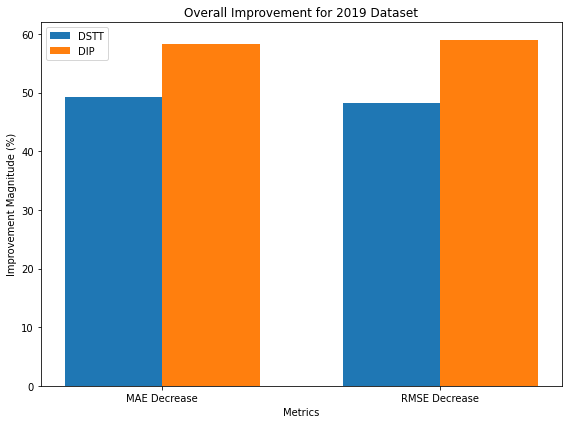

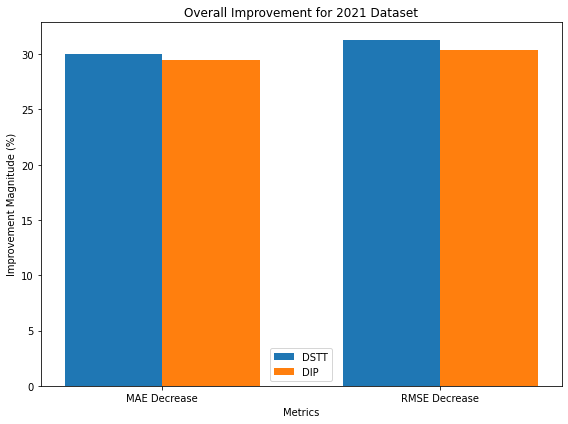

In [6]:
def process_and_compare_models_with_overall_plotting(gt_file_dstt, org_dstt_file, inp_dstt_file, gt_file_dip, org_dip_file, inp_dip_file, label):
    """
    Modified version to focus on MAE and RMSE improvements, excluding R2 from the comparison.
    
    Parameters:
    - gt_file_dstt, org_dstt_file, inp_dstt_file: File paths for ground truth, original, and inpainted DSTT datasets.
    - gt_file_dip, org_dip_file, inp_dip_file: File paths for ground truth, original, and inpainted DIP datasets.
    - label: A label for the dataset being processed (e.g., '2019 Dataset').
    """
    # Load the data
    gt_dstt = load_data(gt_file_dstt)
    org_dstt = load_data(org_dstt_file)
    inp_dstt = load_data(inp_dstt_file)
    gt_dip = load_data(gt_file_dip)
    org_dip = load_data(org_dip_file)
    inp_dip = load_data(inp_dip_file)

    differences_summary = []
    
    for attribute in ['Average Wavelength', 'Average Depth', 'Average Wave Direction']:
        metrics_dstt_org = calculate_metrics(gt_dstt[attribute], org_dstt[attribute])
        metrics_dstt_inp = calculate_metrics(gt_dstt[attribute], inp_dstt[attribute])
        metrics_dip_org = calculate_metrics(gt_dip[attribute], org_dip[attribute])
        metrics_dip_inp = calculate_metrics(gt_dip[attribute], inp_dip[attribute])

        # Focusing on MAE and RMSE improvements only
        dstt_differences = (metrics_dstt_org[0] - metrics_dstt_inp[0], metrics_dstt_org[1] - metrics_dstt_inp[1])
        dip_differences = (metrics_dip_org[0] - metrics_dip_inp[0], metrics_dip_org[1] - metrics_dip_inp[1])
        differences_summary.append((dstt_differences, dip_differences))
    
    # Aggregate differences across attributes for MAE and RMSE only
    overall_differences = np.mean(differences_summary, axis=0)
    improvements = ['MAE Decrease', 'RMSE Decrease']
    metrics = ['DSTT', 'DIP']
    
    # Plotting the overall differences without R2
    fig, ax = plt.subplots(figsize=(8, 6))
    bar_width = 0.35
    index = np.arange(len(improvements))
    
    # Make the plot
    for i, metric in enumerate(metrics):
        values = overall_differences[i]
        plt.bar(index + i*bar_width, values, bar_width, label=metric)
    
    plt.xlabel('Metrics')
    plt.ylabel('Improvement Magnitude (%)')
    plt.title(f'Overall Improvement for {label}')
    plt.xticks(index + bar_width / 2, improvements)
    plt.legend()
    plt.tight_layout()
    plt.show()


process_and_compare_models_with_overall_plotting('batch_process_results_GROUNDTRUTH_DSTT_2019.csv', 'batch_process_results_ORG_DSTT_2019.csv', 'batch_process_results_INPAINTED_DSTT_2019.csv', 'batch_process_results_GROUNDTRUTH_DIP_2019.csv', 'batch_process_results_ORG_DIP_2019.csv', 'batch_process_results_INPAINTED_DIP_2019.csv', '2019 Dataset')
process_and_compare_models_with_overall_plotting('batch_process_results_GROUNDTRUTH_DSTT_2021.csv', 'batch_process_results_ORG_DSTT_2021.csv', 'batch_process_results_INPAINTED_DSTT_2021.csv', 'batch_process_results_GROUNDTRUTH_DIP_2021.csv', 'batch_process_results_ORG_DIP_2021.csv', 'batch_process_results_INPAINTED_DIP_2021.csv', '2021 Dataset')

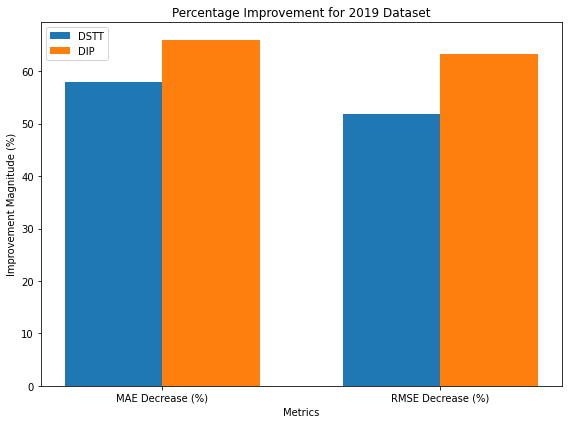

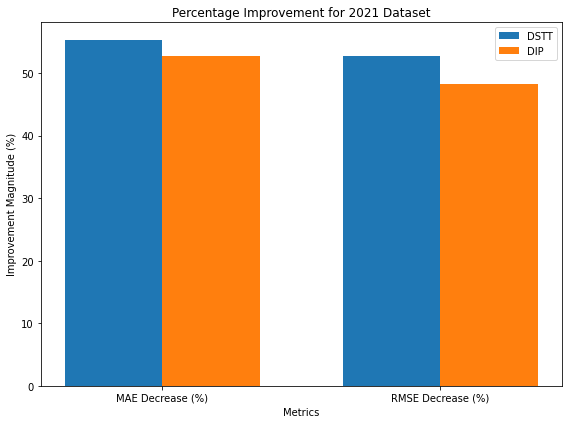

In [7]:
#BY percentage difference

def process_and_compare_models_with_percentage_improvements(gt_file_dstt, org_dstt_file, inp_dstt_file, gt_file_dip, org_dip_file, inp_dip_file, label):
    """
    Modified version to calculate and plot percentage improvements for MAE and RMSE, excluding R2.
    
    Parameters:
    - gt_file_dstt, org_dstt_file, inp_dstt_file: File paths for ground truth, original, and inpainted DSTT datasets.
    - gt_file_dip, org_dip_file, inp_dip_file: File paths for ground truth, original, and inpainted DIP datasets.
    - label: A label for the dataset being processed (e.g., '2019 Dataset').
    """
    # Load the data
    gt_dstt = load_data(gt_file_dstt)
    org_dstt = load_data(org_dstt_file)
    inp_dstt = load_data(inp_dstt_file)
    gt_dip = load_data(gt_file_dip)
    org_dip = load_data(org_dip_file)
    inp_dip = load_data(inp_dip_file)

    percentage_differences_summary = []
    
    for attribute in ['Average Wavelength', 'Average Depth', 'Average Wave Direction']:
        metrics_dstt_org = calculate_metrics(gt_dstt[attribute], org_dstt[attribute])
        metrics_dstt_inp = calculate_metrics(gt_dstt[attribute], inp_dstt[attribute])
        metrics_dip_org = calculate_metrics(gt_dip[attribute], org_dip[attribute])
        metrics_dip_inp = calculate_metrics(gt_dip[attribute], inp_dip[attribute])

        # Calculate percentage improvements for MAE and RMSE
        dstt_mae_improvement_pct = ((metrics_dstt_org[0] - metrics_dstt_inp[0]) / metrics_dstt_org[0]) * 100
        dstt_rmse_improvement_pct = ((metrics_dstt_org[1] - metrics_dstt_inp[1]) / metrics_dstt_org[1]) * 100
        
        dip_mae_improvement_pct = ((metrics_dip_org[0] - metrics_dip_inp[0]) / metrics_dip_org[0]) * 100
        dip_rmse_improvement_pct = ((metrics_dip_org[1] - metrics_dip_inp[1]) / metrics_dip_org[1]) * 100

        percentage_differences_summary.append(((dstt_mae_improvement_pct, dstt_rmse_improvement_pct), (dip_mae_improvement_pct, dip_rmse_improvement_pct)))
    
    # Aggregate percentage improvements across attributes for MAE and RMSE only
    overall_percentage_improvements = np.mean(percentage_differences_summary, axis=0)
    improvements = ['MAE Decrease (%)', 'RMSE Decrease (%)']
    metrics = ['DSTT', 'DIP']
    
    # Plotting the overall percentage improvements
    fig, ax = plt.subplots(figsize=(8, 6))
    bar_width = 0.35
    index = np.arange(len(improvements))
    
    # Make the plot
    for i, metric in enumerate(metrics):
        values = overall_percentage_improvements[i]
        plt.bar(index + i*bar_width, values, bar_width, label=metric)
    
    plt.xlabel('Metrics')
    plt.ylabel('Improvement Magnitude (%)')
    plt.title(f'Percentage Improvement for {label}')
    plt.xticks(index + bar_width / 2, improvements)
    plt.legend()
    plt.tight_layout()
    plt.show()

process_and_compare_models_with_percentage_improvements('batch_process_results_GROUNDTRUTH_DSTT_2019.csv', 'batch_process_results_ORG_DSTT_2019.csv', 'batch_process_results_INPAINTED_DSTT_2019.csv', 'batch_process_results_GROUNDTRUTH_DIP_2019.csv', 'batch_process_results_ORG_DIP_2019.csv', 'batch_process_results_INPAINTED_DIP_2019.csv', '2019 Dataset')
process_and_compare_models_with_percentage_improvements('batch_process_results_GROUNDTRUTH_DSTT_2021.csv', 'batch_process_results_ORG_DSTT_2021.csv', 'batch_process_results_INPAINTED_DSTT_2021.csv', 'batch_process_results_GROUNDTRUTH_DIP_2021.csv', 'batch_process_results_ORG_DIP_2021.csv', 'batch_process_results_INPAINTED_DIP_2021.csv', '2021 Dataset')

[56.5964683  52.33447937]
[59.33822398 55.79592301]


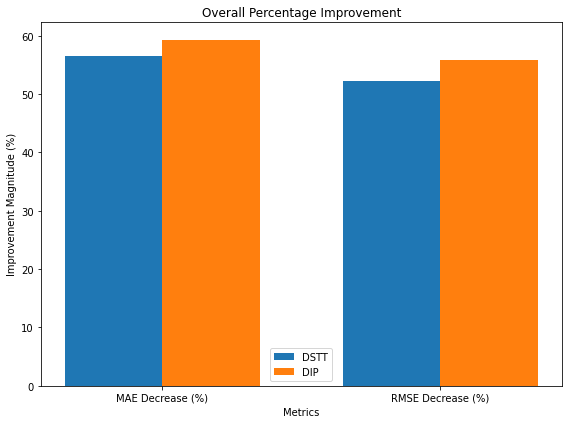

In [8]:
def process_and_compare_models_combined_percentage_improvements(gt_files_dstt, org_files_dstt, inp_files_dstt, gt_files_dip, org_files_dip, inp_files_dip):
    """
    Adapted to combine and analyze data from multiple years (e.g., 2019 and 2021) for DSTT and DIP datasets,
    calculating and plotting overall percentage improvements for MAE and RMSE.
    
    Parameters:
    - gt_files_dstt, org_files_dstt, inp_files_dstt: Lists of file paths for ground truth, original, and inpainted DSTT datasets across years.
    - gt_files_dip, org_files_dip, inp_files_dip: Lists of file paths for ground truth, original, and inpainted DIP datasets across years.
    - label: A label for the combined dataset being processed (e.g., 'Combined 2019-2021 Dataset').
    """
    combined_percentage_differences_summary = []
    
    # Process each year's data and aggregate the results
    for gt_file_dstt, org_dstt_file, inp_dstt_file, gt_file_dip, org_dip_file, inp_dip_file in zip(gt_files_dstt, org_files_dstt, inp_files_dstt, gt_files_dip, org_files_dip, inp_files_dip):
        gt_dstt = load_data(gt_file_dstt)
        org_dstt = load_data(org_dstt_file)
        inp_dstt = load_data(inp_dstt_file)
        gt_dip = load_data(gt_file_dip)
        org_dip = load_data(org_dip_file)
        inp_dip = load_data(inp_dip_file)

        for attribute in ['Average Wavelength', 'Average Depth', 'Average Wave Direction']:
            metrics_dstt_org = calculate_metrics(gt_dstt[attribute], org_dstt[attribute])
            metrics_dstt_inp = calculate_metrics(gt_dstt[attribute], inp_dstt[attribute])
            metrics_dip_org = calculate_metrics(gt_dip[attribute], org_dip[attribute])
            metrics_dip_inp = calculate_metrics(gt_dip[attribute], inp_dip[attribute])

            # Calculate percentage improvements for MAE and RMSE
            dstt_mae_improvement_pct = ((metrics_dstt_org[0] - metrics_dstt_inp[0]) / metrics_dstt_org[0]) * 100
            dstt_rmse_improvement_pct = ((metrics_dstt_org[1] - metrics_dstt_inp[1]) / metrics_dstt_org[1]) * 100
            dip_mae_improvement_pct = ((metrics_dip_org[0] - metrics_dip_inp[0]) / metrics_dip_org[0]) * 100
            dip_rmse_improvement_pct = ((metrics_dip_org[1] - metrics_dip_inp[1]) / metrics_dip_org[1]) * 100

            combined_percentage_differences_summary.append(((dstt_mae_improvement_pct, dstt_rmse_improvement_pct), (dip_mae_improvement_pct, dip_rmse_improvement_pct)))
    
    # Aggregate percentage improvements across all attributes and years for MAE and RMSE only
    overall_percentage_improvements = np.mean(combined_percentage_differences_summary, axis=0)
    improvements = ['MAE Decrease (%)', 'RMSE Decrease (%)']
    metrics = ['DSTT', 'DIP']
    
    # Plotting the overall percentage improvements
    fig, ax = plt.subplots(figsize=(8, 6))
    bar_width = 0.35
    index = np.arange(len(improvements))
    
    for i, metric in enumerate(metrics):
        values = overall_percentage_improvements[i]
        print (values)
        plt.bar(index + i*bar_width, values, bar_width, label=metric)
    
    plt.xlabel('Metrics')
    plt.ylabel('Improvement Magnitude (%)')
    plt.title(f'Overall Percentage Improvement')
    plt.xticks(index + bar_width / 2, improvements)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    

# The function call is commented to avoid execution in this environment. To use, pass the file paths for each dataset year.
process_and_compare_models_combined_percentage_improvements(
     ['batch_process_results_GROUNDTRUTH_DSTT_2019.csv', 'batch_process_results_GROUNDTRUTH_DSTT_2021.csv'],
     ['batch_process_results_ORG_DSTT_2019.csv', 'batch_process_results_ORG_DSTT_2021.csv'],
     ['batch_process_results_INPAINTED_DSTT_2019.csv', 'batch_process_results_INPAINTED_DSTT_2021.csv'],
     ['batch_process_results_GROUNDTRUTH_DIP_2019.csv', 'batch_process_results_GROUNDTRUTH_DIP_2021.csv'],
     ['batch_process_results_ORG_DIP_2019.csv', 'batch_process_results_ORG_DIP_2021.csv'],
     ['batch_process_results_INPAINTED_DIP_2019.csv', 'batch_process_results_INPAINTED_DIP_2021.csv'])
    
